In [6]:
# Импорт
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data.load import load_unsw_nb15_parquet
from src.data.preprocessor import CategoricalPreprocessor, analyze_categorical_features, handle_rare_categories
from pathlib import Path
# Загрузка данных
df = load_unsw_nb15_parquet('../data/raw')
print(f"Загружено: {df.shape}")

# Анализ категориальных признаков перед обработкой
categorical_columns = ['proto', 'service', 'state']
analyze_categorical_features(df, categorical_columns)

Нашёл! 2 файлов:
 - UNSW_NB15_testing-set.parquet
 - UNSW_NB15_training-set.parquet
Загружаем UNSW_NB15_testing-set.parquet...
  Shape: (82332, 36)
  Columns: 36
Загружаем UNSW_NB15_training-set.parquet...
  Shape: (175341, 36)
  Columns: 36
Датасет установлен успешно: 257673 строки, 36 столбцы
Загружено: (257673, 36)
Анализ категориальных признаков

--- proto ---
Уникальных значений: 133
Пропущенных значений: 0
Топ-5 значений:
proto
tcp     123041
udp      92701
unas     15599
arp       3846
ospf      3271
Name: count, dtype: int64
Много уникальных значений! Думай чё делать

--- service ---
Уникальных значений: 13
Пропущенных значений: 0
Топ-5 значений:
service
-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
Name: count, dtype: int64
Подходит для One-Hot Encoding

--- state ---
Уникальных значений: 11
Пропущенных значений: 0
Топ-5 значений:
state
FIN    117164
INT    116438
CON     20134
REQ      3833
RST        84
Name: count, dtype: int

In [7]:
df_processed = handle_rare_categories(df, categorical_columns, threshold=0.01)

# Проверяем результат
for col in categorical_columns:
    if col in df_processed.columns:
        print(f"\n{col} после обработки редких категорий:")
        print(f"Уникальных значений: {df_processed[col].nunique()}")
        print("Распределение:")
        print(df_processed[col].value_counts().head())

Объединено 128 редких категорий в 'proto'
Объединено 7 редких категорий в 'service'
Объединено 7 редких категорий в 'state'

proto после обработки редких категорий:
Уникальных значений: 6
Распределение:
proto
tcp      123041
udp       92701
other     19215
unas      15599
arp        3846
Name: count, dtype: int64

service после обработки редких категорий:
Уникальных значений: 7
Распределение:
service
-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
Name: count, dtype: int64

state после обработки редких категорий:
Уникальных значений: 5
Распределение:
state
FIN      117164
INT      116438
CON       20134
REQ        3833
other       104
Name: count, dtype: int64


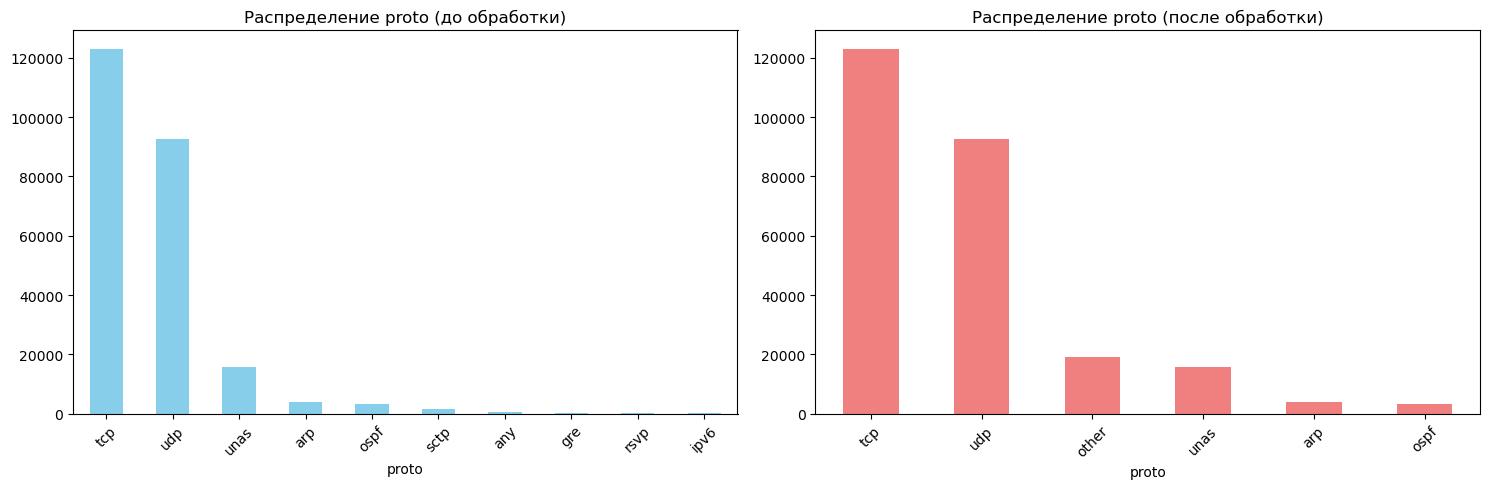

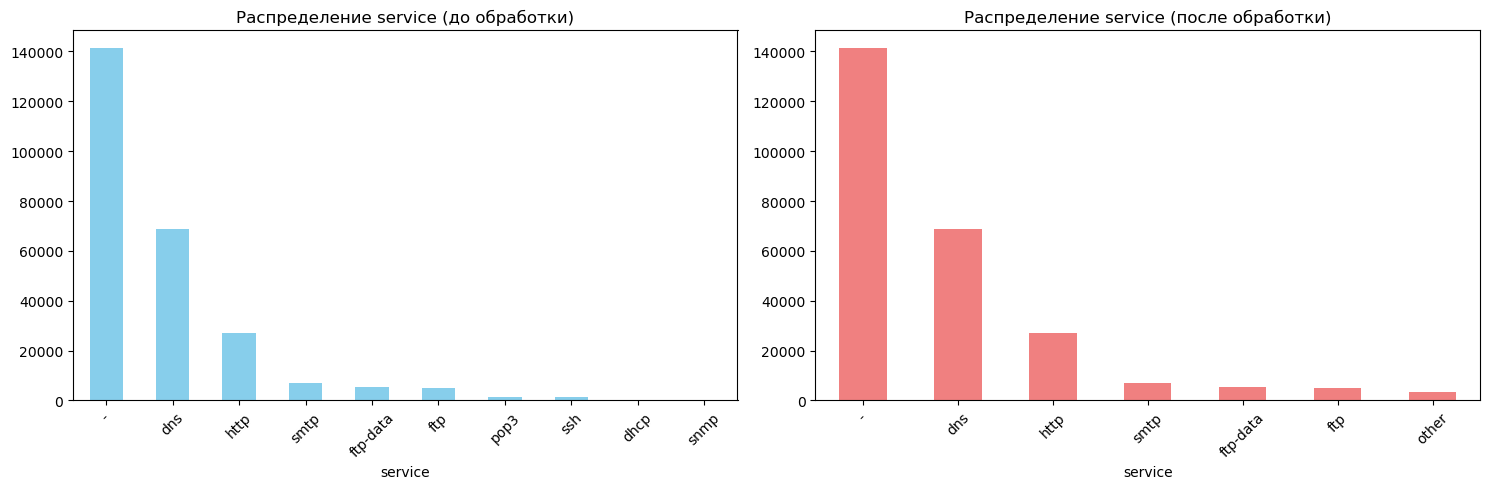

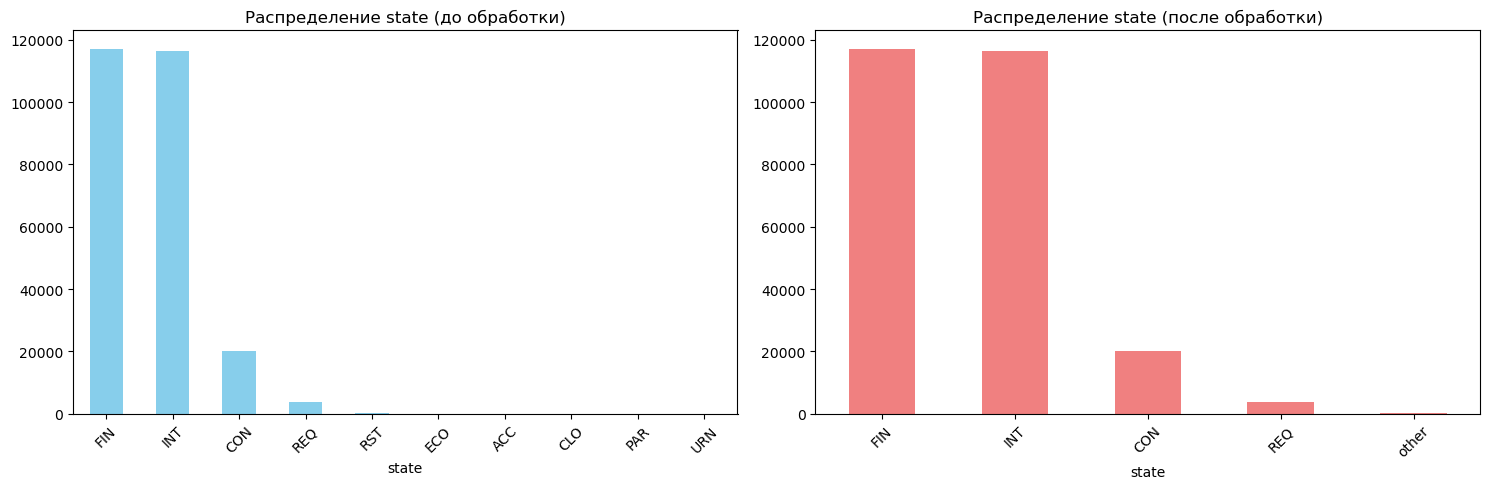

In [8]:
# Визуализация изменений
def plot_categorical_comparison(original_df, processed_df, column):
    """Сравнение распределения до и после обработки"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # До обработки
    original_df[column].value_counts().head(10).plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title(f'Распределение {column} (до обработки)')
    ax1.tick_params(axis='x', rotation=45)
    
    # После обработки
    processed_df[column].value_counts().head(10).plot(kind='bar', ax=ax2, color='lightcoral')
    ax2.set_title(f'Распределение {column} (после обработки)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Визуализируем для каждого категориального признака
for col in categorical_columns:
    if col in df.columns:
        plot_categorical_comparison(df, df_processed, col)

In [9]:
# Создаем и обучаем препроцессор
print("\nСоздание пайплайна для предобработки")
preprocessor = CategoricalPreprocessor()

# Разделяем данные на признаки и целевую переменную
X = df_processed.drop(['label', 'attack_cat'], axis=1, errors='ignore')  # удаляем целевые переменные
y_binary = df_processed['label']  # для бинарной классификации
y_multiclass = df_processed.get('attack_cat', None)  # для многоклассовой (если есть)

print(f"Признаки для обработки: {X.shape}")

# Обучаем и преобразуем данные
X_processed = preprocessor.fit_transform(X)

print(f"После One-Hot Encoding: {X_processed.shape}")
print(f"Пример преобразованных данных:")
print(X_processed.head())

# Анализ результата
print("\nАнализ результатов")
print(f"Исходное количество признаков: {X.shape[1]}")
print(f"После кодирования: {X_processed.shape[1]}")
print(f"Увеличение в {X_processed.shape[1] / X.shape[1]:.1f} раз")

# Смотрим на созданные One-Hot признаки
onehot_columns = [col for col in X_processed.columns if 'cat__' in col]
print(f"\nСоздано One-Hot признаков: {len(onehot_columns)}")
print("Примеры One-Hot колонок:")
print(onehot_columns[:10])  # первые 10


Создание пайплайна для предобработки
Признаки для обработки: (257673, 34)
Препроцессор обучен
Данные преобразованы: 49 признаков
После One-Hot Encoding: (257673, 49)
Пример преобразованных данных:
   cat__proto_arp  cat__proto_ospf  cat__proto_other  cat__proto_tcp  \
0             0.0              0.0               0.0             0.0   
1             0.0              0.0               0.0             0.0   
2             0.0              0.0               0.0             0.0   
3             0.0              0.0               0.0             0.0   
4             0.0              0.0               0.0             0.0   

   cat__proto_udp  cat__proto_unas  cat__service_-  cat__service_dns  \
0             1.0              0.0             1.0               0.0   
1             1.0              0.0             1.0               0.0   
2             1.0              0.0             1.0               0.0   
3             1.0              0.0             1.0               0.0   
4        

In [10]:
# Сохраняем обработанные данные
output_path = Path("../data/processed")
output_path.mkdir(parents=True, exist_ok=True)

# Сохраняем преобразованные признаки
X_processed.to_parquet(output_path / "X_processed.parquet", index=False)

# Сохраняем целевые переменные
y_binary.to_frame().to_parquet(output_path / "y_binary.parquet", index=False)
if y_multiclass is not None:
    y_multiclass.to_frame().to_parquet(output_path / "y_multiclass.parquet", index=False)

print("Обработанные данные сохранены")

# Сохраняем обученный препроцессор
models_path = Path("../models")
models_path.mkdir(parents=True, exist_ok=True)
preprocessor.save(models_path / "categorical_preprocessor.joblib")

Обработанные данные сохранены
Препроцессор сохранен в ..\models\categorical_preprocessor.joblib


In [12]:
# Проверка, что не потеряли информацию
def check_transformation_quality(original_df, processed_df, target_col='label'):
    """Проверка качества преобразования"""
    print("\nПроверка качества преобразования")
    
    # Проверяем, что количество строк не изменилось
    if len(original_df) != len(processed_df):
        print("Потеряны строки при преобразовании!")
        return
    
    # Проверяем, что таргет не изменился
    if target_col in original_df.columns:
        original_target = original_df[target_col]
        # processed_target = ...  # если вы сохранили таргет отдельно
        
        print(f"Количество строк сохранено: {len(original_df)}")
        print(f"Количество признаков увеличено с {original_df.shape[1]} до {processed_df.shape[1]}")
        print(f"One-Hot Encoding применен корректно")
    
    # Проверяем, что нет пропусков в преобразованных данных
    missing_after = processed_df.isnull().sum().sum()
    if missing_after == 0:
        print("Пропущенных значений нет")
    else:
        print(f"Осталось пропусков: {missing_after}")

check_transformation_quality(X, X_processed)


Проверка качества преобразования
Пропущенных значений нет


In [13]:
# Генерация отчета о предобработке
def generate_preprocessing_report(original_df, processed_df, categorical_columns):
    """Генерация отчета о проделанной работе"""
    
    report = f"""
ОТЧЕТ О ПРЕДОБРАБОТКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
{'='*50}

ИСХОДНЫЕ ДАННЫЕ:
- Количество записей: {len(original_df):,}
- Количество признаков: {original_df.shape[1]}
- Категориальные признаки: {categorical_columns}

ВЫПОЛНЕННЫЕ ПРЕОБРАЗОВАНИЯ:
1. Анализ категориальных признаков
2. Обработка редких категорий (объединение в 'other')
3. One-Hot Encoding категориальных признаков
4. Обработка пропущенных значений

РЕЗУЛЬТАТ:
- Новое количество признаков: {processed_df.shape[1]}
- Увеличение: в {processed_df.shape[1] / original_df.shape[1]:.1f} раз
- One-Hot признаков создано: {len([col for col in processed_df.columns if 'cat__' in col])}

ДЕТАЛИ ПО ПРИЗНАКАМ:
"""
    
    for col in categorical_columns:
        if col in original_df.columns:
            unique_before = original_df[col].nunique()
            # После обработки считаем One-Hot колонки для этого признака
            onehot_for_feature = len([c for c in processed_df.columns if f'cat__{col}_' in c])
            
            report += f"- {col}: {unique_before} уникальных → {onehot_for_feature} бинарных признаков\n"
    
    report += f"\nПРЕДОБРАБОТКА ЗАВЕРШЕНА УСПЕШНО"
    
    return report

# Генерируем и сохраняем отчет
report = generate_preprocessing_report(X, X_processed, categorical_columns)
print(report)

# Сохраняем отчет
with open(output_path / "preprocessing_report.txt", "w", encoding='utf-8') as f:
    f.write(report)


ОТЧЕТ О ПРЕДОБРАБОТКИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

ИСХОДНЫЕ ДАННЫЕ:
- Количество записей: 257,673
- Количество признаков: 34
- Категориальные признаки: ['proto', 'service', 'state']

ВЫПОЛНЕННЫЕ ПРЕОБРАЗОВАНИЯ:
1. Анализ категориальных признаков
2. Обработка редких категорий (объединение в 'other')
3. One-Hot Encoding категориальных признаков
4. Обработка пропущенных значений

РЕЗУЛЬТАТ:
- Новое количество признаков: 49
- Увеличение: в 1.4 раз
- One-Hot признаков создано: 18

ДЕТАЛИ ПО ПРИЗНАКАМ:
- proto: 6 уникальных → 6 бинарных признаков
- service: 7 уникальных → 7 бинарных признаков
- state: 5 уникальных → 5 бинарных признаков

ПРЕДОБРАБОТКА ЗАВЕРШЕНА УСПЕШНО
